# MNS 6

Dominik Krzemiński

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pdb

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [62]:
def expand_kwargs(kwargsdict, i):
    new_kwarg = {}
    for k, val in kwargsdict.items():
        if np.isscalar(val) or hasattr(val, '__call__'): # we skip scalars and functions
            new_kwarg[k] = val
            continue
        new_kwarg[k] = val[i]
    return new_kwarg

def euler_par(f_func, x_0, timevec, **params):
    dt = timevec[-1] - timevec[-2]
    n = len(timevec)
    x = np.zeros((n,1))
    x[0] = x_0
    for i in range(1, n):
        kw = expand_kwargs(params, i)
        x[i] = x[i-1] + f_func(x[i-1], timevec[i-1], **kw)*dt
    return x.T

def euler_hh(v_0, n0, m0, h0, timevec, ek, ena, ie0, retall=False):
    dt = timevec[-1] - timevec[-2]
    n  = len(timevec)
    v   = np.zeros((n,1))
    ina = np.zeros((n,1))
    ik  = np.zeros((n,1))
    nvec = np.zeros((n,1))
    mvec = np.zeros((n,1))
    hvec = np.zeros((n,1))
    v[0] = v_0
    nvec[0] = n0
    mvec[0] = m0
    hvec[0] = h0
    for i in range(1, n):
        nvec[i] = nvec[i-1] + dxdt(nvec[i-1], timevec[i-1], v[i-1], alpha=alpha_n, beta=beta_n)*dt
        mvec[i] = mvec[i-1] + dxdt(mvec[i-1], timevec[i-1], v[i-1], alpha=alpha_m, beta=beta_m)*dt
        hvec[i] = hvec[i-1] + dxdt(hvec[i-1], timevec[i-1], v[i-1], alpha=alpha_h, beta=beta_h)*dt
        ik[i]  = gk*(nvec[i]**4)*(v[i-1]-ek)
        ina[i] = gna*(mvec[i]**3)*hvec[i]*(v[i-1]-ena)
        if not np.isscalar(ie0):
            v[i] = v[i-1] + vfun(ina[i], ik[i], i_leak(v[i-1]), ie=ie0[i])*dt
            continue
        v[i] = v[i-1] + vfun(ina[i], ik[i], i_leak(v[i-1]), ie=ie0)*dt
    if retall:
        return v.T, ina.T, ik.T, nvec.T
    return v.T


In [3]:
def alpha_n(v):
    return (0.01*(v + 55))/(1 - np.exp(-0.1*(v+55)))

def beta_n(v):
    return 0.125*np.exp(-0.0125*(v + 65))

def alpha_m(v):
    return (0.1*(v + 40))/(1 - np.exp(-0.1*(v+40)))

def alpha_h(v):
    return 0.07*np.exp(-0.05*(v+65))

def beta_m(v):
    return 4*np.exp(-0.0556*(v + 65))

def beta_h(v):
    return (1+np.exp(-0.1*(v + 35)))**-1

def dxdt(x, t, v=0, alpha=alpha_n, beta=beta_n):
    return alpha(v)*(1-x)-beta(v)*x

def ik(v, tv, n0, gk=36e-9, ek=-77):
    nvec = euler_par(dxdt, n0, tv, v=v, alpha=alpha_n, beta=beta_n)
    return gk*(nvec**4)*(v-ek)

def ina(v, tv, m0, h0, gna=120e-9, ena=50):
    mvec = euler_par(dxdt, m0, tv, v=v, alpha=alpha_m, beta=beta_m)
    hvec = euler_par(dxdt, h0, tv, v=v, alpha=alpha_h, beta=beta_h)
    return gna*(mvec**3)*hvec*(v-ena)

tau_n = lambda v: (alpha_n(v) + beta_n(v))**-1
n_inf = lambda v: alpha_n(v)*(alpha_n(v) + beta_n(v))**-1

tau_m = lambda v: (alpha_m(v) + beta_m(v))**-1
m_inf = lambda v: alpha_m(v)*(alpha_m(v) + beta_m(v))**-1

tau_h = lambda v: (alpha_h(v) + beta_h(v))**-1
h_inf = lambda v: alpha_h(v)*(alpha_h(v) + beta_h(v))**-1

In [4]:
i_e = 0 #A
c_m = 1*1e-9 #F
v_0 = -65 # mV
m0 = 0.0529
h0 = 0.5961
n0 = 0.3177

gk, ek = 36e-9, -77
gna, ena = 120e-9, 50

In [5]:
def i_leak(v, gleak=0.3*1e-9, e_leak=-54.387):
    return gleak*(v-e_leak)

def vfun(ina, ik, ileak, ie=0):
    return (-ina - ik - ileak + ie)/c_m

In [6]:
dt = 1./200
t_max = 50
tv = np.arange(0, t_max, dt)
hhv = euler_hh(v_0, n0, m0, h0, tv, ek, ena, i_e)

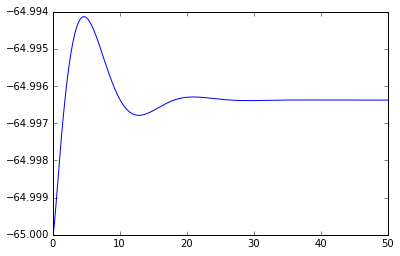

In [7]:
ax = plt.gca()
ax.plot(tv, hhv[0])
ax.ticklabel_format(useOffset=False)
plt.show()

b)

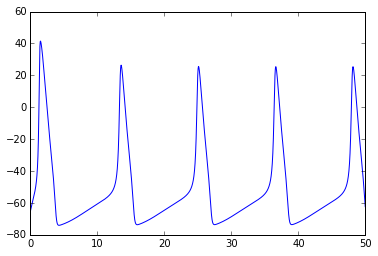

In [9]:
i_e2 = 20*1e-9 #A
hhvb, inavecb, ikvecb, nvec = euler_hh(v_0, n0, m0, h0, tv, ek, ena, i_e2, True)
ax = plt.gca()
ax.plot(tv, hhvb[0])
ax.ticklabel_format(useOffset=False)
plt.show()

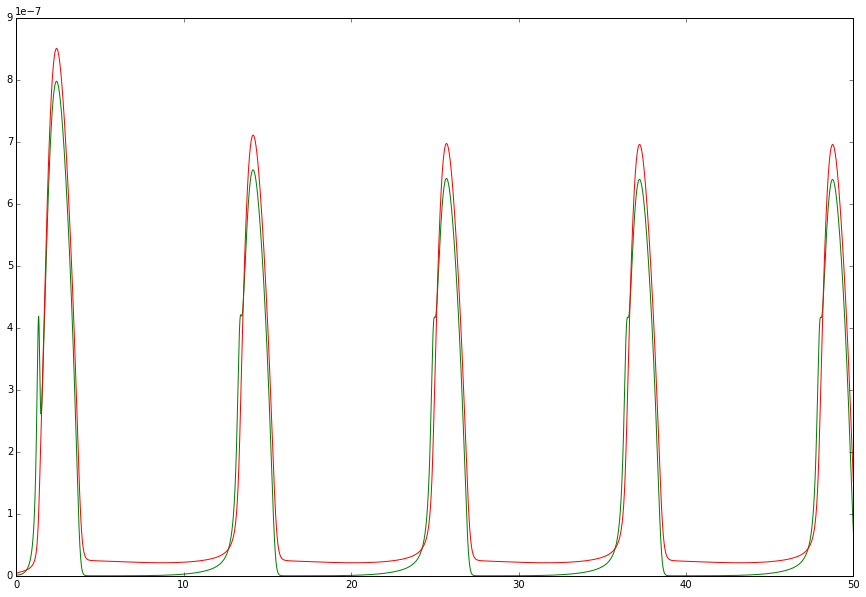

In [10]:
plt.figure(figsize=(15,10))
ax = plt.gca()
ax.plot(tv, -inavecb[0], 'g', label='Na')
ax.plot(tv, ikvecb[0], 'r', label='K')
ax.ticklabel_format(useOffset=False)
plt.show()

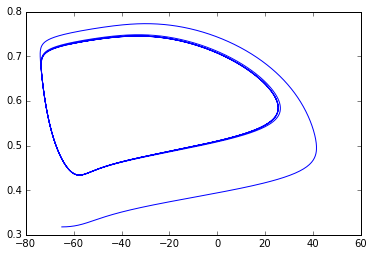

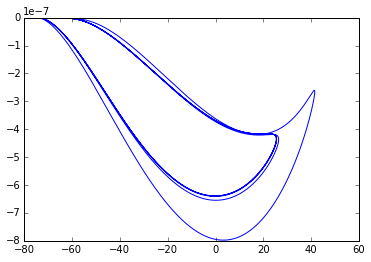

In [12]:
plt.plot(hhvb[0], nvec[0])
plt.show()

plt.plot(hhvb[0], inavecb[0])
plt.show()


c)

In [47]:
def compute_fr(volt, thresh=0):
    n = len(volt[0])
    logic_v = (volt[0]>thresh).astype(int)
    idxs = []
    for i in range(1, n):
        if logic_v[i-1]==0 and logic_v[i]==1:
            idxs.append(i)
    try:
        fr = 100./(tv[idxs[-1]]-tv[idxs[-2]])
    except IndexError:
        fr = 0
    return fr

In [59]:
ievec = np.linspace(0, 200, 20)*1e-9 #A
rates = np.zeros(len(ievec))
for e,iev in enumerate(ievec):
    hhv_ = euler_hh(v_0, n0, m0, h0, tv, ek, ena, iev)
    rates[e] = compute_fr(hhv_)

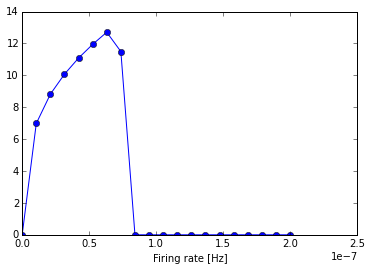

In [63]:
plt.plot(ievec, rates)
plt.plot(ievec, rates, 'bo')
plt.xlabel('I_e')
plt.xlabel('Firing rate [Hz]')
plt.show()


d)

In [60]:
iepulse = np.zeros(len(tv))
iepulse[15./dt:20./dt] = -5*1e-9 # A

In [66]:
hhvd, inavecd, ikvecd, nvecd  = euler_hh(v_0, n0, m0, h0, tv, ek, ena, iepulse, True)

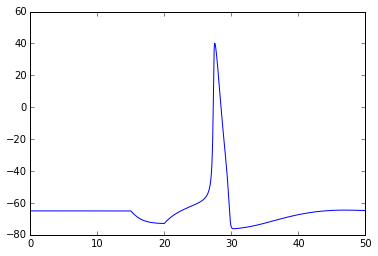

In [67]:
ax = plt.gca()
ax.plot(tv, hhvd[0])
ax.ticklabel_format(useOffset=False)
plt.show()

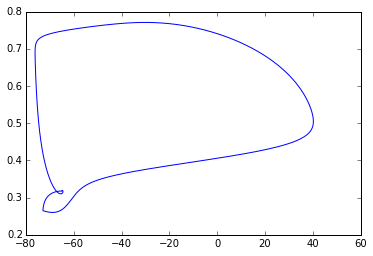

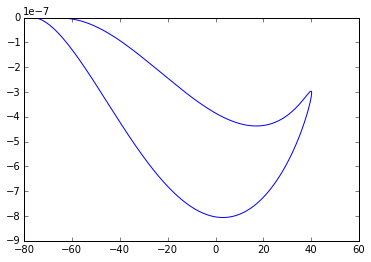

In [68]:
plt.plot(hhvd[0], nvecd[0])
plt.show()

plt.plot(hhvd[0], inavecd[0])
plt.show()
